In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Activation
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import *
from google.colab import drive
from keras.callbacks import EarlyStopping
import pathlib
import os

drive.mount('/content/gdrive', force_remount=True)
data_dir = "/content/gdrive/MyDrive/M.sc Data Mining/Medicine imaging/data"
data_dir = pathlib.Path(data_dir)
!ls "/content/gdrive/MyDrive/M.sc Data Mining/Medicine imaging/data"

BATCH_SIZE = 32


Mounted at /content/gdrive
01  02	03


In [11]:
def load_train_validation_data(img_height=210, img_width=210):

  IMG_SIZE = (img_height, img_width)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

  return train_ds, val_ds


In [12]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

186


**DenseNet121 - this is our best model**

In [13]:
def plot_accuracy_graph(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()



In [14]:

img_height = 210
img_width = 210

train_ds, val_ds = load_train_validation_data(img_height, img_width)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load the pre-trained ResNet model
densnet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(210, 210, 3))

# Freeze the layers of the pre-trained model
for layer in densnet_model.layers:
    layer.trainable = False

# Replace the output layer with a new layer for your task
x = Flatten()(densnet_model.output)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=densnet_model.input, outputs=x)
epochs=8
# Train the model on your own dataset
learning_rate = 2e-4
decay_steps = 10
decay_rate = 1

# Khởi tạo learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss = SparseCategoricalCrossentropy(from_logits=True),metrics =['accuracy'])
# model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=32)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 95s 7s/step - loss: 2.6523 - accuracy: 0.5771 - val_loss: 0.6546 - val_accuracy: 0.8200
Epoch 2/8
7/7 [==============================] - 33s 5s/step - loss: 1.0600 - accuracy: 0.8607 - val_loss: 0.6400 - val_accuracy: 0.8400
Epoch 3/8
7/7 [==============================] - 36s 5s/step - loss: 0.3794 - accuracy: 0.9005 - val_loss: 0.6353 - val_accuracy: 0.8600
Epoch 4/8
7/7 [==============================] - 36s 5s/step - loss: 0.2894 - accuracy: 0.9154 - val_loss: 0.2560 - val_accuracy: 0.9200
Epoch 5/8
7/7 [==============================] - 37s 5s/step - loss: 0.1474 - accuracy: 0.9552 - val_loss: 0.4915 - val_accuracy: 0.9000
Epoch 6/8
7/7 [==============================] - 32s 5s/step - loss: 0.0442 - accuracy: 0.9851 - val_loss: 0.2506 - val_accuracy: 0.9400
Epoch 7/8
7/7 [==============================] - 37s 5s/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.3279 - val_accuracy: 0.9400
Epoch 8/8
7/7 [==============================] - 39

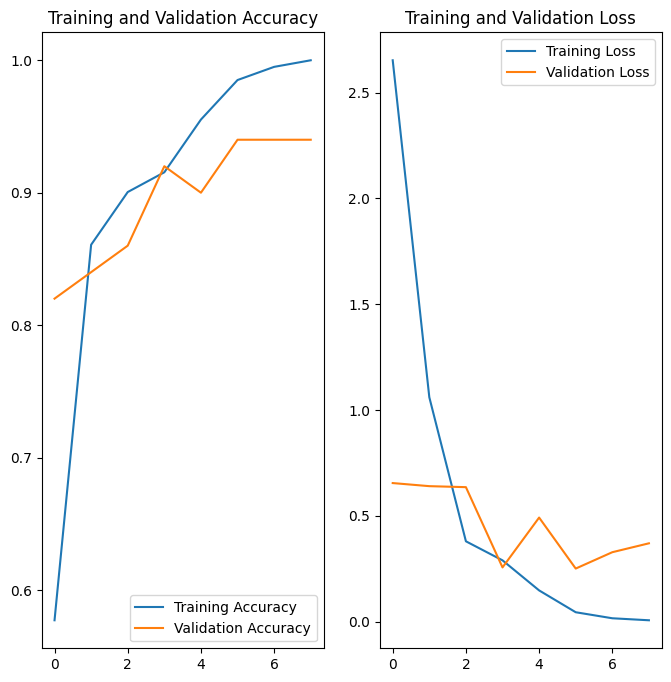

In [16]:
plot_accuracy_graph(history, epochs)

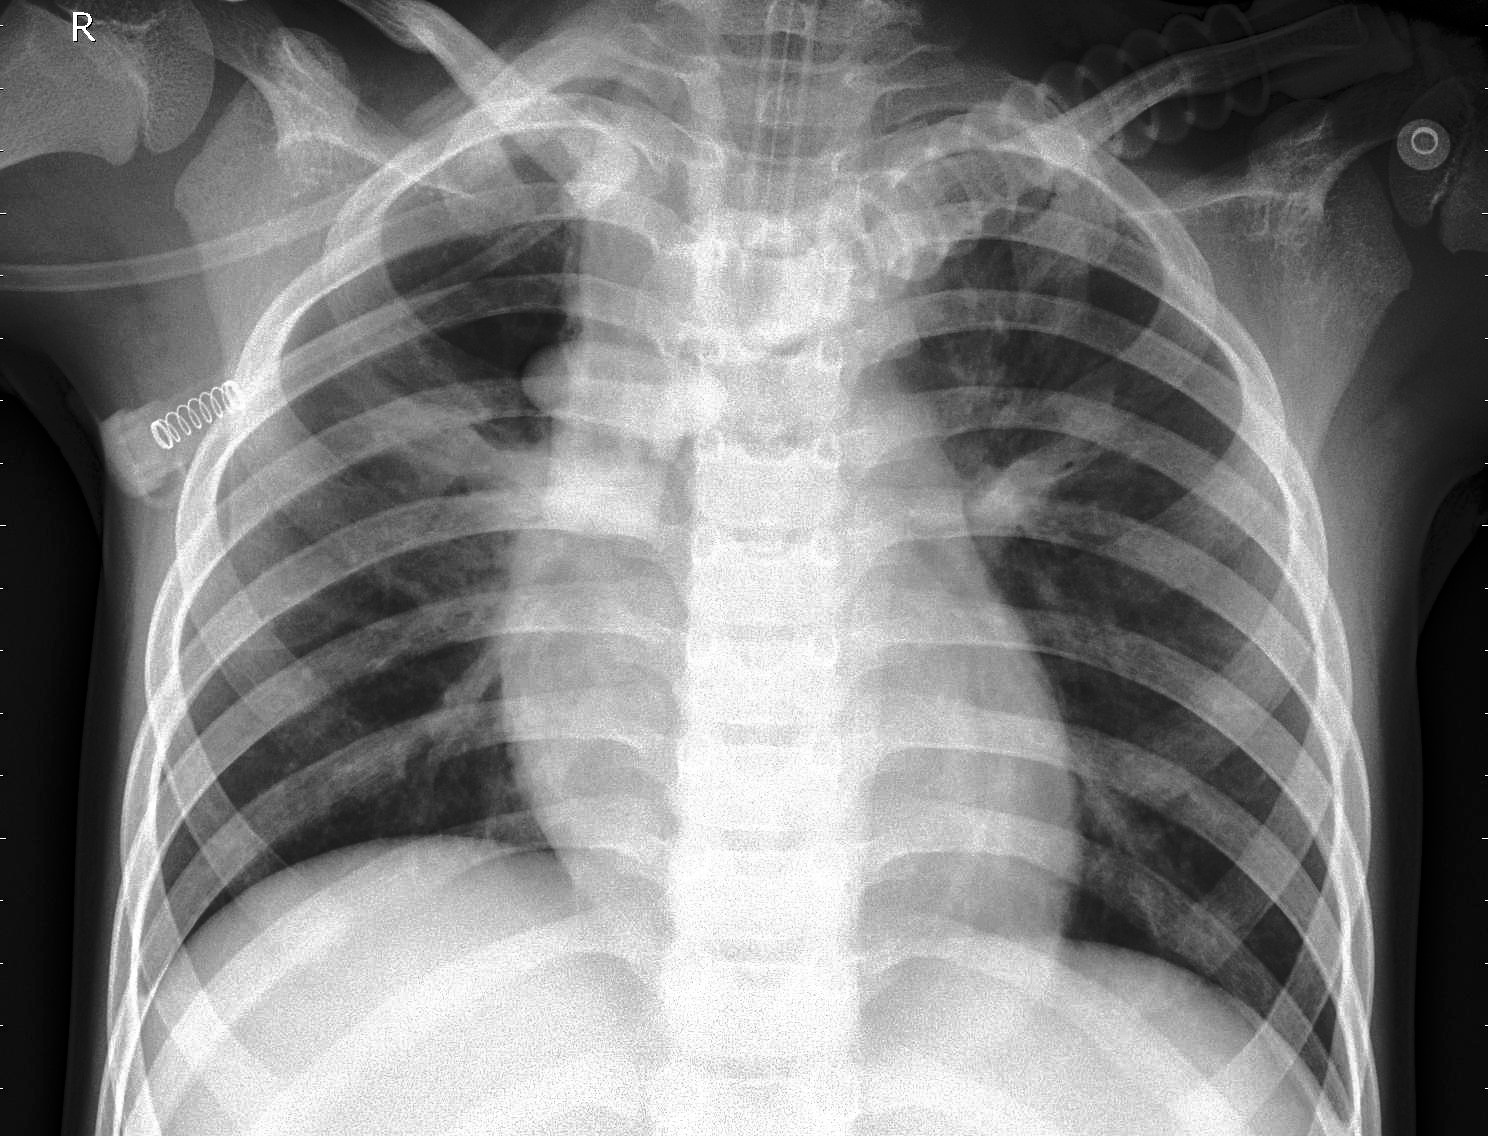

In [17]:
first = list(data_dir.glob('01/*'))

PIL.Image.open(str(first[5]))

In [18]:
img_height=210
img_width=210
train_ds, val_ds = load_train_validation_data(img_height, img_width)
class_names = train_ds.class_names
print(class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
['01', '02', '03']
(32, 210, 210, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(train_ds)

0.0 1.0
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 210, 210, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [20]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 0


In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

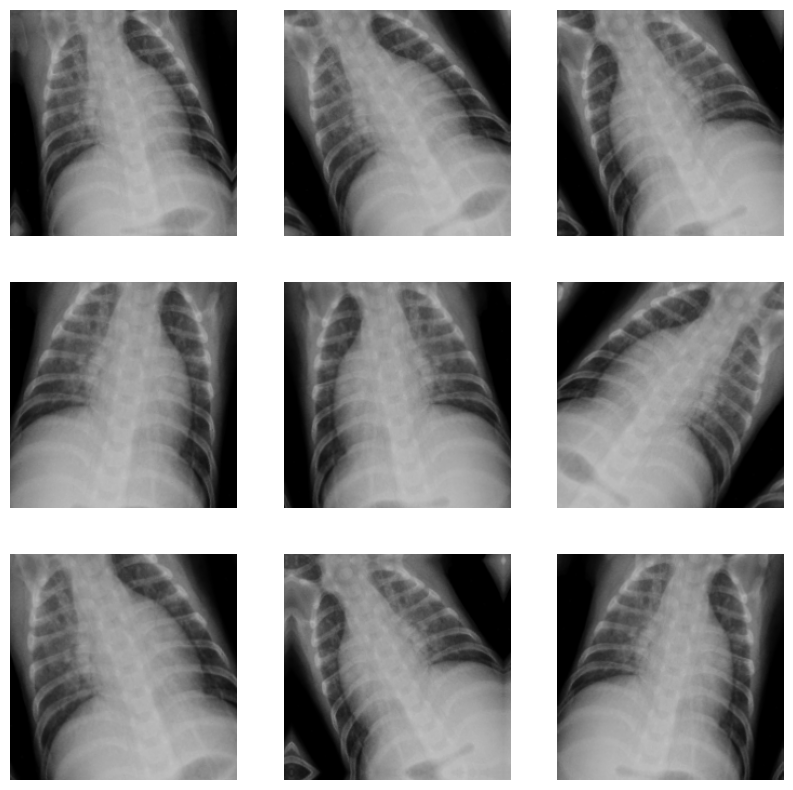

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**CNN reference model**

In [23]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
7/7 [==============================] - 16s 2s/step - loss: 2.6342 - accuracy: 0.4378 - val_loss: 1.0366 - val_accuracy: 0.3800
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 1.0451 - accuracy: 0.4627 - val_loss: 1.0207 - val_accuracy: 0.4800
Epoch 3/20
7/7 [==============================] - 11s 2s/step - loss: 0.9767 - accuracy: 0.5871 - val_loss: 0.9257 - val_accuracy: 0.5800
Epoch 4/20
7/7 [==============================] - 12s 2s/step - loss: 0.8463 - accuracy: 0.6766 - val_loss: 0.9008 - val_accuracy: 0.4800
Epoch 5/20
7/7 [==============================] - 12s 2s/step - loss: 0.6564 - accuracy: 0.7164 - val_loss: 0.5602 - val_accuracy: 0.8000
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.5521 - accuracy: 0.7562 - val_loss: 0.5515 - val_accuracy: 0.7200
Epoch 7/20
7/7 [==============================] - 11s 1s/step - loss: 0.4884 - accuracy: 0.7811 - val_loss: 0.3327 - val_accuracy: 0.9000
Epoch 8/20
7/7 [===================

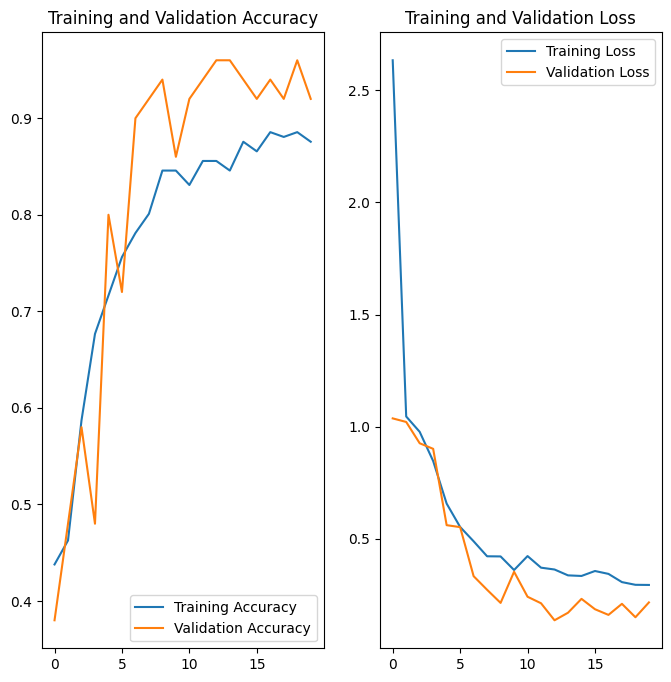

In [24]:
plot_accuracy_graph(history, epochs)

In [25]:
model.save("vanilla_algo_with augmentation.keras")